<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
!pip install numpy==1.24.4


In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [5]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2025-03-30 18:22:32--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2025-03-30 18:22:32--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0.002s  

2025-03-30 18:22:33 (15.0 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2025-03-30 18:22:33--
Total wall clock time: 0.3s
Downloaded: 1 files, 23K in 0.002s (15.0 MB/s)


In [ ]:
from torch_helpers import Tokenizer # tool de keras equivalente a ltokenizer de nltk
from torch_helpers import text_to_word_sequence # tool de keras equivalente a word_teokenize de nltk
from torch_helpers import pad_sequences # tool de keras qye se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [6]:
from torch_helpers import categorical_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data.to(device)).cpu()

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        #valid_data, valid_target = iter(valid_loader).next() Version vieja
        valid_data, valid_target = next(iter(valid_loader))

        output = model(valid_data.to(device)).cpu()

        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### Datos
Utilizaremos como dataset las peliculas de los avengers

In [7]:
def load_avengers_scripts(file_paths, movie_names):
    data = []
    for file_path, movie_name in zip(file_paths, movie_names):
        with open(file_path, 'r', encoding='latin-1') as f:
            lines = f.read().splitlines()
            for line in lines:
                if line.strip():
                    data.append({
                        "texto": line,

                    })

    df = pd.DataFrame(data, columns=["texto"])
    return df

In [8]:
file_paths = [
        "/content/Avengers.Age.of.Ultron.txt",
        "/content/Avengers.Endgame.txt",
        "/content/Avengers.Infinity.War.txt",
        "/content/Avengers.txt"
    ]

movie_names = [
    "Avengers: Age of Ultron",
    "Avengers: Endgame",
    "Avengers: Infinity War",
    "The Avengers"
]

df = load_avengers_scripts(file_paths, movie_names)

print(df.head())
print(f"\nTotal de líneas combinadas: {len(df)}")

                                               texto
0                                (DISTANT EXPLOSION)
1  STRUCKER ON PA: Report to your stations immedi...
2                               This is not a drill.
3                               We are under attack!
4                   (SOLDIERS SHOUTING INDISTINCTLY)

Total de líneas combinadas: 7793


In [9]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 7793


## 1 - Preprocesamiento de datos

### Vistazo a las primeras filas

In [24]:
df.iloc[:15,0]

,texto
0,(DISTANT EXPLOSION)
1,STRUCKER ON PA: Report to your stations immedi...
2,This is not a drill.
3,We are under attack!
4,(SOLDIERS SHOUTING INDISTINCTLY)
5,We are under attack!
6,(GRUNTS)
7,(POWERING UP)
8,(YELLS)
9,(GRUNTING)


### Concatenamos todos los rows en un solo valor

In [105]:
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]

<ipython-input-105-9eca7dd73672>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]


### Transformar el corpus a tokens

In [106]:
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['distant',
 'explosion',
 'strucker',
 'on',
 'pa',
 'report',
 'to',
 'your',
 'stations',
 'immediately',
 'this',
 'is',
 'not',
 'a',
 'drill',
 'we',
 'are',
 'under',
 'attack',
 'soldiers']

In [27]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 42244


In [28]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [29]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['distant', 'explosion', 'strucker', 'on'],
 ['explosion', 'strucker', 'on', 'pa'],
 ['strucker', 'on', 'pa', 'report'],
 ['on', 'pa', 'report', 'to'],
 ['pa', 'report', 'to', 'your'],
 ['report', 'to', 'your', 'stations'],
 ['to', 'your', 'stations', 'immediately'],
 ['your', 'stations', 'immediately', 'this'],
 ['stations', 'immediately', 'this', 'is'],
 ['immediately', 'this', 'is', 'not'],
 ['this', 'is', 'not', 'a'],
 ['is', 'not', 'a', 'drill'],
 ['not', 'a', 'drill', 'we'],
 ['a', 'drill', 'we', 'are'],
 ['drill', 'we', 'are', 'under'],
 ['we', 'are', 'under', 'attack'],
 ['are', 'under', 'attack', 'soldiers'],
 ['under', 'attack', 'soldiers', 'shouting'],
 ['attack', 'soldiers', 'shouting', 'indistinctly'],
 ['soldiers', 'shouting', 'indistinctly', 'we']]

### Proceso de tokenizacion

In [30]:
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[4589, 4588, 414, 14],
 [4588, 414, 14, 2224],
 [414, 14, 2224, 931],
 [14, 2224, 931, 4],
 [2224, 931, 4, 28],
 [931, 4, 28, 1140],
 [4, 28, 1140, 1141],
 [28, 1140, 1141, 12],
 [1140, 1141, 12, 8],
 [1141, 12, 8, 17],
 [12, 8, 17, 5],
 [8, 17, 5, 1142],
 [17, 5, 1142, 7],
 [5, 1142, 7, 21],
 [1142, 7, 21, 306],
 [7, 21, 306, 544],
 [21, 306, 544, 580],
 [306, 544, 580, 581],
 [544, 580, 581, 2225],
 [580, 581, 2225, 7]]

In [31]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 42240


## 2 - Input y target

In [35]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1]

print(x_data.shape)
print(y_data_int.shape)

(42240, 3)
(42240,)


In [108]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'the',
 3: 'i',
 4: 'to',
 5: 'a',
 6: 'it',
 7: 'we',
 8: 'is',
 9: 'that',
 10: 'of',
 11: 'and',
 12: 'this',
 13: 'in',
 14: 'on',
 15: 'what',
 16: 'me',
 17: 'not',
 18: 'no',
 19: "i'm",
 20: "it's",
 21: 'are',
 22: 'for',
 23: 'have',
 24: 'he',
 25: 'know',
 26: 'be',
 27: 'all',
 28: 'your',
 29: 'do',
 30: "don't",
 31: 'my',
 32: 'right',
 33: 'but',
 34: "you're",
 35: 'was',
 36: 'if',
 37: 'get',
 38: 'got',
 39: 'so',
 40: 'here',
 41: 'out',
 42: 'yeah',
 43: 'up',
 44: 'one',
 45: 'can',
 46: 'like',
 47: 'with',
 48: 'just',
 49: 'time',
 50: 'him',
 51: 'go',
 52: "that's",
 53: 'there',
 54: 'they',
 55: 'gonna',
 56: 'about',
 57: 'now',
 58: 'will',
 59: 'stark',
 60: 'did',
 61: "we're",
 62: "he's",
 63: 'need',
 64: 'back',
 65: 'think',
 66: 'okay',
 67: 'how',
 68: 'come',
 69: 'at',
 70: 'them',
 71: 'well',
 72: 'oh',
 73: 'an',
 74: 'our',
 75: 'us',
 76: 'going',
 77: 'where',
 78: 'want',
 79: 'down',
 80: 'as',
 81: 'from',
 82: 'his',


In [37]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

4589

In [38]:
# ¡Ojo! y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [39]:
# Hay que restar 1
y_data_int_offset = y_data_int - 1
min(y_data_int_offset)

0

In [111]:
assert (y_data_int > 0).all()


Aclaracion:

No realice one-hot encoding porque CrossEntropyLoss no lo necesita. Esta función espera que las etiquetas sean índices enteros de clase, no vectores. Si hiciéramos one-hot, estaríamos pasando un formato incorrecto y el loss no funcionaría como corresponde.

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [41]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores.
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        #self.y = F.one_hot(torch.from_numpy(y), num_classes=vocab_size).float()
        self.y = torch.from_numpy(y.astype(np.int64))


        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(x_data, y_data_int_offset)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

#output_dim = data_set.y.shape[1]
output_dim = vocab_size

print("Output dim", output_dim)

input_size: 3
Output dim 4589


In [42]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 33792
Tamaño del conjunto de validacion: 8448


## 3 - Entrenar el modelo

Aclaraciones:

Hice algunas modifiicaciones en el dropout para evitar overfitting

No usamos softmax en la última capa porque CrossEntropyLoss ya lo aplica internamente. Si lo agregábamos nosotros, estaríamos duplicando esa operación, lo cual puede generar inestabilidad numérica y hacer que el modelo aprenda peor. Por eso dejamos que la última capa devuelva directamente los logits.

In [80]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size --> 1628 palabras distintas + 1 para padding o UNK
        # embedding_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=5, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=5, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.5) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=32) # Fully connected layer
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim) # Fully connected layer

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state=None):
        if prev_state is None:
            # En cada nueva inferencia reinicio el hidden state
            # de la LSTM al menos que sea pasado por parámetro el
            # elstado de previo
            # Esta acción se realiza especialmente para que
            # el hidden_state de la última inferencia no afecte
            # a la siguiente
            batch_size = x.shape[0] #(batch, seq_size)
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:,-1,:]))
        #out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device))

In [81]:
model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)
if cuda: model1.cuda()

model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)

model1_criterion = torch.nn.CrossEntropyLoss()


In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)


### Summary

In [83]:
input_tensor = data_set[0][0].unsqueeze(0).to(device)

# Mostrar resumen del modelo
summary(model1, input_data=input_tensor)

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 4589]                 --
├─Embedding: 1-1                         [1, 3, 5]                 22,950
├─LSTM: 1-2                              [1, 3, 64]                51,456
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 4589]                 151,437
Total params: 227,923
Trainable params: 227,923
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.33
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.91
Estimated Total Size (MB): 0.95

In [47]:
def categorical_acc(y_pred, y_test):
    y_pred_tag = y_pred.data.max(dim=1, keepdim=True)[1]
    y_test_tag = y_test.view(-1, 1)
    correct_results_sum = (y_pred_tag == y_test_tag).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    return acc


In [48]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=100
                )

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1/100 - Train loss 6.643 - Train accuracy 0.032 - Valid Loss 6.563 - Valid accuracy 0.037
Epoch: 2/100 - Train loss 6.379 - Train accuracy 0.034 - Valid Loss 6.517 - Valid accuracy 0.038
Epoch: 3/100 - Train loss 6.344 - Train accuracy 0.036 - Valid Loss 6.494 - Valid accuracy 0.039
Epoch: 4/100 - Train loss 6.296 - Train accuracy 0.040 - Valid Loss 6.459 - Valid accuracy 0.043
Epoch: 5/100 - Train loss 6.204 - Train accuracy 0.044 - Valid Loss 6.387 - Valid accuracy 0.044
Epoch: 6/100 - Train loss 6.087 - Train accuracy 0.047 - Valid Loss 6.344 - Valid accuracy 0.047
Epoch: 7/100 - Train loss 6.005 - Train accuracy 0.049 - Valid Loss 6.342 - Valid accuracy 0.047
Epoch: 8/100 - Train loss 5.946 - Train accuracy 0.050 - Valid Loss 6.328 - Valid accuracy 0.050
Epoch: 9/100 - Train loss 5.890 - Train accuracy 0.054 - Valid Loss 6.321 - Valid accuracy 0.056
Epoch: 10/100 - Train loss 5.838 - Train accuracy 0.057 - Valid Loss 6.307 - Valid accuracy 0.054
Epoch: 11/100 - Train loss 5.

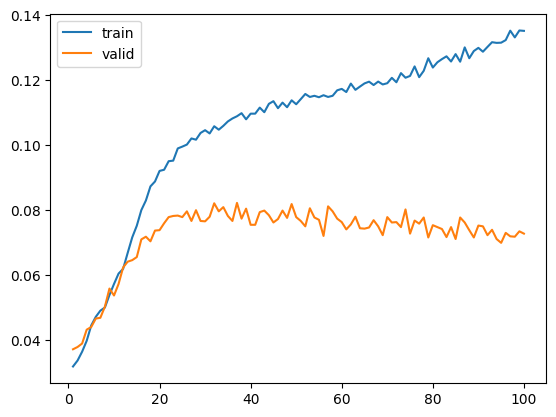

In [49]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

In [50]:
# Guarda solo los pesos del modelo
torch.save(model1.state_dict(), "model1_weights.pth")


## Cargar modelo

In [51]:
model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)
model1.load_state_dict(torch.load("model1_weights.pth"))
model1.to(device)
model1.eval()


Model1(
  (embedding): Embedding(4590, 5, padding_idx=0)
  (lstm1): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=4589, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

## 4 - Predicción de próxima palabra

In [85]:
def predict_next_word(model, tokenizer, input_text, max_len=3):
    """
    Predice la próxima palabra dada una frase de entrada.

    Args:
        model (torch.nn.Module): Modelo entrenado.
        tokenizer (Tokenizer): Tokenizador ya ajustado.
        input_text (str): Frase inicial.
        max_len (int): Longitud máxima de entrada (usada en pad_sequences).

    Returns:
        str: Frase con la palabra predicha añadida.
    """
    model.eval()

    # Tokenizar y preprocesar
    encoded = tokenizer.texts_to_sequences([input_text])[0]
    padded = pad_sequences([encoded], maxlen=max_len, padding='pre')
    tensor = torch.from_numpy(padded.astype(np.int32)).to(device)

    # Predecir
    with torch.no_grad():
        output = model(tensor)
        predicted_idx = output.argmax(dim=-1).item()

    predicted_word = None
    for word, index in tokenizer.word_index.items():
        if index == predicted_idx + 1:
            predicted_word = word
            break

    predicted_word = predicted_word if predicted_word is not None else "<UNK>"

    return input_text + " " + predicted_word


In [91]:
input_text = "bring me thanos"
output = predict_next_word(model1, tok, input_text)
print(output)


bring me thanos defeating


In [92]:
input_text = "hi how are"
output = predict_next_word(model1, tok, input_text)
print(output)

hi how are defeating


In [93]:
input_text = "i am"
output = predict_next_word(model1, tok, input_text)
print(output)

i am defeating


In [94]:
input_text = "tony stark is"
output = predict_next_word(model1, tok, input_text)
print(output)

tony stark is defeating


por alguna razon siempre predeci que la siguiente palabra es defeating. Por lo que el modelo no es el mejor.

## 5 - Generación de secuencias nuevas

In [59]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        # Transformo a tensor
        tensor = torch.from_numpy(encoded.astype(np.int32)).to(device)
        # Predicción softmax
        y_hat = model1(tensor).argmax(axis=-1)

		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [97]:
input_text='i am iron'

generate_seq(model1, tok, input_text, max_length=3, n_words=2)

'i am iron threatens threatens'

## 6 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

Voy a aplicar las siguientes recomendaciones para ver si mejora el modelo:

In [75]:
class ModelBonus(Model1):
    def __init__(self, vocab_size, output_dim):
        super().__init__(vocab_size, output_dim)

        self.bidirectional = True
        self.embedding_dim = 5
        self.lstm_size = 32
        self.num_layers = 2
        self.embedding = nn.Embedding(num_embeddings=vocab_size + 1,
                                      embedding_dim=self.embedding_dim,
                                      padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim,
                             hidden_size=self.lstm_size,
                             num_layers=self.num_layers,
                             dropout=0.6,
                             batch_first=True,
                             bidirectional=self.bidirectional)

        # Ajustamos los Linear para bidireccional
        self.fc1 = nn.Linear(in_features=self.lstm_size * 2, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim)

        self.relu = nn.ReLU()

    def forward(self, x, prev_state=None):
        if prev_state is None:
            batch_size = x.shape[0]
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:, -1, :]))
        out = self.fc2(out)  # sin softmax porque usamos CrossEntropy
        return out

    def init_hidden(self, batch_size):
        num_directions = 2 if self.bidirectional else 1
        return (
            torch.zeros(self.num_layers * num_directions, batch_size, self.lstm_size).to(device),
            torch.zeros(self.num_layers * num_directions, batch_size, self.lstm_size).to(device),
        )


In [76]:
model2 = ModelBonus(vocab_size=vocab_size, output_dim=output_dim)
if cuda: model2.cuda()

model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-5)

model2_criterion = torch.nn.CrossEntropyLoss()

In [77]:
model2 = model2.to(device)

In [78]:
# Mostrar resumen del modelo
summary(model2, input_data=input_tensor)

Layer (type:depth-idx)                   Output Shape              Param #
ModelBonus                               [1, 4589]                 --
├─Embedding: 1-1                         [1, 3, 5]                 22,950
├─LSTM: 1-2                              [1, 3, 64]                35,072
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 4589]                 151,437
Total params: 211,539
Trainable params: 211,539
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.28
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.85
Estimated Total Size (MB): 0.88

In [79]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=30
                )

Epoch: 1/30 - Train loss 6.665 - Train accuracy 0.032 - Valid Loss 6.642 - Valid accuracy 0.037
Epoch: 2/30 - Train loss 6.347 - Train accuracy 0.035 - Valid Loss 6.571 - Valid accuracy 0.040
Epoch: 3/30 - Train loss 6.234 - Train accuracy 0.039 - Valid Loss 6.482 - Valid accuracy 0.041
Epoch: 4/30 - Train loss 6.124 - Train accuracy 0.042 - Valid Loss 6.420 - Valid accuracy 0.041
Epoch: 5/30 - Train loss 6.036 - Train accuracy 0.044 - Valid Loss 6.395 - Valid accuracy 0.046
Epoch: 6/30 - Train loss 5.965 - Train accuracy 0.051 - Valid Loss 6.367 - Valid accuracy 0.049
Epoch: 7/30 - Train loss 5.886 - Train accuracy 0.055 - Valid Loss 6.338 - Valid accuracy 0.051
Epoch: 8/30 - Train loss 5.809 - Train accuracy 0.058 - Valid Loss 6.321 - Valid accuracy 0.056
Epoch: 9/30 - Train loss 5.736 - Train accuracy 0.062 - Valid Loss 6.315 - Valid accuracy 0.059
Epoch: 10/30 - Train loss 5.667 - Train accuracy 0.065 - Valid Loss 6.319 - Valid accuracy 0.065
Epoch: 11/30 - Train loss 5.604 - Train

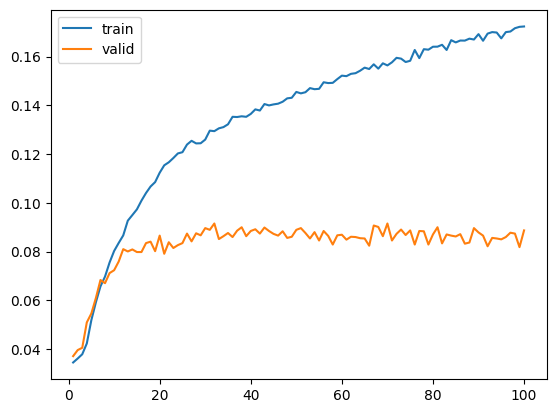

In [69]:
epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
plt.show()

In [70]:
torch.save(model2.state_dict(), "model2_weights.pth")

In [103]:
test_phrases = [
    "bring me thanos",
    "hi how are",
    "i am",
    "tony stark is",
    "i am iron",
    "we have a",
    "i can do",
    "avengers assemble on",
    "whatever it takes",
    "you should have",
    "i love you"
]


for text in test_phrases:
    output = predict_next_word(model2, tok, text)
    print(f"Input:  {text}")
    print(f"Output: {output}")
    print("-" * 40)


Input:  bring me thanos
Output: bring me thanos h
----------------------------------------
Input:  hi how are
Output: hi how are you
----------------------------------------
Input:  i am
Output: i am groot
----------------------------------------
Input:  tony stark is
Output: tony stark is it
----------------------------------------
Input:  i am iron
Output: i am iron and
----------------------------------------
Input:  we have a
Output: we have a lot
----------------------------------------
Input:  i can do
Output: i can do you
----------------------------------------
Input:  avengers assemble on
Output: avengers assemble on the
----------------------------------------
Input:  whatever it takes
Output: whatever it takes it
----------------------------------------
Input:  you should have
Output: you should have the
----------------------------------------
Input:  i love you
Output: i love you to
----------------------------------------


In [104]:
# Comparacion con modelo1
test_phrases = [
    "bring me thanos",
    "hi how are",
    "i am",
    "tony stark is",
    "i am iron",
    "we have a",
    "i can do",
    "avengers assemble on",
    "whatever it takes",
    "you should have",
    "i love you"
]


for text in test_phrases:
    output = predict_next_word(model1, tok, text)
    print(f"Input:  {text}")
    print(f"Output: {output}")
    print("-" * 40)


Input:  bring me thanos
Output: bring me thanos defeating
----------------------------------------
Input:  hi how are
Output: hi how are defeating
----------------------------------------
Input:  i am
Output: i am defeating
----------------------------------------
Input:  tony stark is
Output: tony stark is defeating
----------------------------------------
Input:  i am iron
Output: i am iron defeating
----------------------------------------
Input:  we have a
Output: we have a defeating
----------------------------------------
Input:  i can do
Output: i can do defeating
----------------------------------------
Input:  avengers assemble on
Output: avengers assemble on defeating
----------------------------------------
Input:  whatever it takes
Output: whatever it takes defeating
----------------------------------------
Input:  you should have
Output: you should have defeating
----------------------------------------
Input:  i love you
Output: i love you defeating
----------------------

En conclusión, incorporar una LSTM bidireccional incrementó la capacidad del modelo y permitió una leve mejora en el rendimiento sobre el conjunto de entrenamiento. Sin embargo, el desempeño general sigue siendo limitado, evidenciando que el modelo continúa teniendo dificultades para generalizar. Esto indica que, si bien la bidireccionalidad aporta valor, la arquitectura actual sigue siendo insuficiente para capturar correctamente la complejidad del lenguaje en el dataset de avengers.